<a href="https://colab.research.google.com/github/nandaw/medgemma_experiments/blob/main/notebooks/fine_tune_with_hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~
#Esse notebook foi modificado para fins educacionais


# Fine-tune MedGemma with Hugging Face

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fmedgemma%2Fmain%2Fnotebooks%2Ffine_tune_with_hugging_face.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates fine-tuning MedGemma on an image and text dataset for a vision task using Hugging Face libraries.

In this guide, you will use Hugging Face's [Transformer Reinforcement Learning (`TRL`)](https://github.com/huggingface/trl) library to train the model with Supervised Fine-Tuning (SFT), utilizing [Quantized Low-Rank Adaptation (QLoRA)](https://arxiv.org/abs/2305.14314) to reduce computational costs while maintaining high performance.


## Setup

To complete this tutorial, you'll need to have a runtime with sufficient resources to fine-tune the MedGemma model. **Note:** This guide requires a GPU that supports bfloat16 data type and has at least 40 GB of memory.

You can run this notebook in Google Colab using an A100 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **A100 GPU**.

### Get access to MedGemma

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-4b-it) and accept the usage conditions.

### Configure your HF token

Generate a Hugging Face `write` access token by going to [settings](https://huggingface.co/settings/tokens). **Note:** Make sure that the token has write access to push the fine-tuned model to Hugging Face Hub.

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

### Install dependencies

In [ ]:
! pip install --upgrade --quiet bitsandbytes datasets evaluate peft tensorboard transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Prepare fine-tuning dataset

This notebook uses the [CBIS-DDSM](https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset) that is an updated and standardized version of the Digital Database for Screening Mammography (DDSM). The DDSM is a database of 2,620 scanned film mammography studies to fine-tune MedGemma to classify tissue types.



**Dataset citation:** https://www.nature.com/articles/sdata2017177

Download the dataset from kaggle. This step may take around 15 minutes to complete.


In [ ]:
! pip install google.colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.7 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

! unzip cbis-ddsm-breast-cancer-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295326067813319071803507885093865003464/1-076.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/2-266.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/1-233.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/1-294.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/2-223.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/1-013.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/2-012.jpg  

In [ ]:
import pandas as pd

In [ ]:
df_dicom = pd.read_csv('/content/csv/dicom_info.csv')
df_dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [ ]:
#full mammogram images
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path

imdir = '/content/'
full_mammo = full_mammo.replace('CBIS-DDSM/', imdir, regex=True)

In [ ]:
full_mammo_dict = dict()
for dicom in full_mammo:
    key = dicom.split("/")[3]
    full_mammo_dict[key] = dicom


In [ ]:
df_calc_train = pd.read_csv('/content/csv/calc_case_description_train_set.csv')
df_calc_val = pd.read_csv('/content/csv/calc_case_description_test_set.csv')
df_calc = pd.concat([df_calc_train, df_calc_val])
df_calc.reset_index(inplace=True, drop=True)

df_mass_train = pd.read_csv('/content/csv/mass_case_description_train_set.csv')
df_mass_val = pd.read_csv('/content/csv/mass_case_description_test_set.csv')
df_mass = pd.concat([df_mass_train, df_mass_val])
df_mass.reset_index(inplace=True, drop=True)

In [ ]:

# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, row in data.iterrows():
        img_name = row['image file path'].split("/")[2]
        try:
          data.loc[index, 'image file path'] = full_mammo_dict[img_name]
        except:
          print(row['image file path'])

# apply to datasets
fix_image_path(df_calc)
fix_image_path(df_mass)

Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992/000000.dcm
Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.384159464510350889125645400702639717613/1.3.6.1.4.1.9590.100.1.2.174390361112646747718661211471328897934/000000.dcm
Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.177706148911820252341905176394069228468/1.3.6.1.4.1.9590.100.1.2.263861248711313923336051913560309963304/000000.dcm
Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.177706148911820252341905176394069228468/1.3.6.1.4.1.9590.100.1.2.263861248711313923336051913560309963304/000000.dcm
Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.328421320411501709324953698601549885215/1.3.6.1.4.1.9590.100.1.2.44262460211112930513355519060642708846/000000.dcm
Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.328421320411501709324953698601549885215/1.3.6.1.4.1.9590.100.1.2.44262460211112930513355519060642708846/00000

In [ ]:
df_calc = df_calc[df_calc['image file path'].str.contains('/content')]
df_mass = df_mass[df_mass['image file path'].str.contains('/content')]

In [ ]:
df_all = pd.concat([df_calc, df_mass])
df_all.reset_index(drop=True, inplace=True)


In [ ]:
df_all['abnormality type'] = df_all['abnormality type'].apply(lambda x: 0 if x == 'calcification' else 1)

In [ ]:
df_all['abnormality type']

,abnormality type
0,0
1,0
2,0
3,0
4,0
...,...
3281,1
3282,1
3283,1
3284,1


In [ ]:
df_all.to_csv('/content/csv/dataset_calc_mass.csv', index=False)

Load the data using the Hugging Face `datasets` library. Then, create train and validation splits.

In [ ]:
from datasets import load_dataset, Image

train_size = 2628  # @param {type: "number"}
validation_size = 658  # @param {type: "number"}

data = load_dataset('csv', data_files="./csv/dataset_calc_mass.csv", split="train")
data = data.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=42,
)
# Use the test split as the validation set
data["validation"] = data.pop("test")

# Cast the 'image file path' column to an Image feature with decode=False
data = data.cast_column("image file path", Image(decode=False))

# Display dataset details
data

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path', 'breast_density', 'mass shape', 'mass margins'],
        num_rows: 2628
    })
    validation: Dataset({
        features: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path', 'breast_density', 'mass shape', 'mass margins'],
        num_rows: 658
    })
})

Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label`: integer class label corresponding to tissue type

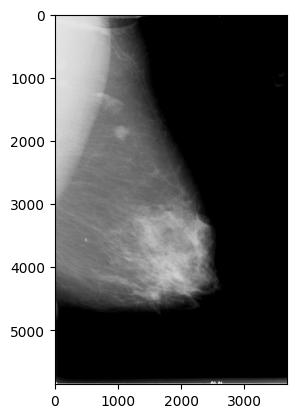

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load and display the image from the file path within the dataset
plt.imshow(Image.open(data["train"][0]["image file path"]["path"]).convert("RGB"))

In [ ]:
data["train"][0]["abnormality type"]

'mass'

For this classification task, create a multiple-choice question prompt and preprocess the data into a multimodal conversational format.

In [ ]:
from typing import Any

ABNORMALITY_TYPES = [
    "calcification",
    "mass",
]


options = "\n".join(ABNORMALITY_TYPES)
PROMPT = f"What is the type of abnormality present in the mammogram image?\n{options}"


def format_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": ABNORMALITY_TYPES[example["abnormality type"]],
                },
            ],
        },
    ]
    return example

Apply the processing function on the dataset.

In [ ]:
data = data.map(format_data)

# Display a processed data sample
data["train"][0]

Map:   0%|          | 0/2628 [00:00<?, ? examples/s]

Map:   0%|          | 0/658 [00:00<?, ? examples/s]

{'patient_id': 'P_00254',
 'breast density': None,
 'left or right breast': 'LEFT',
 'image view': 'MLO',
 'abnormality id': 1,
 'abnormality type': 1,
 'calc type': None,
 'calc distribution': None,
 'assessment': 4,
 'pathology': 'MALIGNANT',
 'subtlety': 4,
 'image file path': {'bytes': None,
  'path': '/content/jpeg/1.3.6.1.4.1.9590.100.1.2.200753917713679520535019007044031244915/1-047.jpg'},
 'cropped image file path': 'Mass-Training_P_00254_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.297896384913731797408895891202116039837/1.3.6.1.4.1.9590.100.1.2.52150460312543935318451424611465351747/000000.dcm',
 'ROI mask file path': 'Mass-Training_P_00254_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.297896384913731797408895891202116039837/1.3.6.1.4.1.9590.100.1.2.52150460312543935318451424611465351747/000001.dcm\n',
 'breast_density': 3.0,
 'mass shape': 'LOBULATED-IRREGULAR',
 'mass margins': 'ILL_DEFINED',
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'What is the type of abnorma

## Fine-tune the model with LoRA

Traditional fine-tuning of large language models is resource-intensive because it requires adjusting billions of parameters. Parameter-Efficient Fine-Tuning (PEFT) addresses this by training a smaller number of parameters. A common PEFT technique is Low-Rank Adaptation (LoRA), which efficiently adapts large language models by training small, low-rank matrices that are added to the original model instead of updating the full-weight matrices. In QLoRA, the base model is quantized to 4-bit before its weights are frozen, then LoRA adapter layers are attached and trained.

This notebook demonstrates supervised fine-tuning MedGemma with QLoRA using the `SFTTrainer` from the Hugging Face `TRL` library.

### Load model from Hugging Face Hub

Initialize the quantization configuration and load the model.

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

### Set up for fine-tuning

Create a [`LoraConfig`](https://huggingface.co/docs/peft/package_reference/lora#peft.LoraConfig). It will be provided to the `SFTTrainer`, which supports built-in integration with the Hugging Face `PEFT` library.

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Define a custom data collator that processes examples containing text and images and returns batches of data in the expected model input format.

In [ ]:
from typing import Any
from PIL import Image


def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []
    for example in examples:
        # Decode the image here within the collate function
        image = Image.open(example["image file path"]["path"]).convert("RGB")
        images.append([image])
        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100 # This seems to be a placeholder token for the image, need to confirm

    batch["labels"] = labels
    return batch

Configure training parameters in an [`SFTConfig`](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

In [ ]:
from trl import SFTConfig

num_train_epochs = 1  # @param {type: "number"}
learning_rate = 2e-4  # @param {type: "number"}

args = SFTConfig(
    output_dir="medgemma-4b-it-sft-lora-crc100k",            # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,                       # Number of training epochs
    per_device_train_batch_size=4,                           # Batch size per device during training
    per_device_eval_batch_size=4,                            # Batch size per device during evaluation
    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=50,                                        # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=50,                                           # Number of steps between evaluations
    learning_rate=learning_rate,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
    push_to_hub=True,                                        # Push model to Hub
    report_to="tensorboard",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.


### Fine-tune the model

Construct an [`SFTTrainer`](https://huggingface.co/docs/trl/sft_trainer) using the previously defined LoRA configuration, custom data collator, and training parameters.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(200)),  # Use subset of validation set for faster run
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

Launch the fine-tuning process.

**Note**: This may take around 2 hours to run using the default configuration.

In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
50,4.965400,0.069739
100,0.261500,0.063266
150,0.251700,0.061592


TrainOutput(global_step=165, training_loss=1.681436469338157, metrics={'train_runtime': 7294.7347, 'train_samples_per_second': 0.36, 'train_steps_per_second': 0.023, 'total_flos': 1.981294567187021e+16, 'train_loss': 1.681436469338157})

Save the final model to Hugging Face Hub.

In [ ]:
trainer.save_model()

Uploading...:   0%|          | 0.00/2.88G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Free up memory before proceeding to evaluate and test the fine-tuned model.



In [ ]:
del model
del trainer
torch.cuda.empty_cache()

## Evaluate the fine-tuned model

### Prepare test dataset


In [ ]:
from typing import Any

from datasets import load_dataset, Image

#if you execute the evaluation step after disconnecting the notebook you will
#need to define the PROMPT or re run the cell with the format_data function

PROMPT = f"What is the type of abnormality present in the mammogram image?\n"

def format_test_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
    ]
    return example


test_data = load_dataset('csv', data_files="./csv/dataset_calc_mass.csv", split="train")
test_data = test_data.shuffle(seed=42).select(range(1000))
# Cast the 'image file path' column to an Image feature with decode=False
test_data = test_data.cast_column("image file path", Image(decode=False))
test_data = test_data.map(format_test_data)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Set up for evaluation

Load the accuracy and F1 score metrics to evaluate the model's performance on the classfication task.

In [ ]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Ground-truth labels
REFERENCES = test_data["abnormality type"]


def compute_metrics(predictions: list[int]) -> dict[str, float]:
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=predictions,
        references=REFERENCES,
    ))
    metrics.update(f1_metric.compute(
        predictions=predictions,
        references=REFERENCES,
        average="weighted",
    ))
    return metrics

Define a postprocessing function to convert responses to integer class labels before computing metrics.

In [ ]:
from datasets import ClassLabel

# Rename the class names to the tissue classes, `X: tissue type`
test_data = test_data.cast_column(
    "abnormality type",
    ClassLabel(names=ABNORMALITY_TYPES)
)

LABEL_FEATURE = test_data.features["abnormality type"]
# Mapping to alternative label format, `(X) tissue type`
# ALT_LABELS = dict([
#     (label, f"({label.replace(': ', ') ')}") for label in ABNORMALITY_TYPES
# ])


def postprocess(prediction: list[dict[str, str]], do_full_match: bool=False) -> int:
    response_text = prediction[0]["generated_text"]
    if do_full_match:
        return LABEL_FEATURE.str2int(response_text)
    for label in ABNORMALITY_TYPES:
        # Search for `X: tissue type` or `(X) tissue type` in the response
        if label in response_text:
            return LABEL_FEATURE.str2int(label)
    return -1

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Compute baseline metrics on the pretrained model

Load the pretrained model using the `pipeline` API.

In [ ]:
import torch
from transformers import pipeline

model_id = "google/medgemma-4b-it"

pt_pipe = pipeline(
    "image-text-to-text",
    model= model_id,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Run batch inference on the test dataset.

In [ ]:
from PIL import Image

# Decode images from the test_data
decoded_images = [Image.open(img_info['path']).convert("RGB") for img_info in test_data["image file path"]]

pt_outputs = pt_pipe(
    text=test_data["messages"],
    images=decoded_images, # Pass the decoded images here
    max_new_tokens=40,
    batch_size=64,
    return_full_text=False,
)

pt_predictions = [postprocess(out) for out in pt_outputs]

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are n

Compute metrics.

In [ ]:
pt_metrics = compute_metrics(pt_predictions)
print(f"Baseline metrics: {pt_metrics}")

Baseline metrics: {'accuracy': 0.486, 'f1': 0.507908992248062}


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
#como liberar a memoria da gpu depois de calcular o baseline com o pre trained? precisei reiniciar o colab

### Compute metrics on the fine-tuned model

Load the base model with the fine-tuned LoRA adapter using the `pipeline` API.

In [ ]:
#colocar essa célula na parte da avaliação do fine tunning
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "nandaw/medgemma-4b-it-sft-lora-crc100k"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)


adapter_config.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline

ft_pipe = pipeline(
    "image-text-to-text",
    model= model_id,
    processor=processor,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
# Use left padding during inference
processor.tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Run batch inference on the test dataset.

In [ ]:
from PIL import Image

# Decode images from the test_data
decoded_images = [Image.open(img_info['path']).convert("RGB") for img_info in test_data["image file path"]]

ft_outputs = ft_pipe(
    text=test_data["messages"],
    images=decoded_images,
    max_new_tokens=20,
    batch_size=64,
    return_full_text=False,
)



The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are n

ValueError: Invalid string class label calcification
mass

In [ ]:

ft_outputs

[[{'input_text': [{'content': [{'text': None,
       'type': 'image',
       'image': <PIL.Image.Image image mode=RGB size=2936x4600>},
      {'text': 'What is the type of abnormality present in the mammogram image?\n',
       'type': 'text'}],
     'role': 'user'}],
   'generated_text': 'calcification\nmass'}],
 [{'input_text': [{'content': [{'text': None,
       'type': 'image',
       'image': <PIL.Image.Image image mode=RGB size=3552x6040>},
      {'text': 'What is the type of abnormality present in the mammogram image?\n',
       'type': 'text'}],
     'role': 'user'}],
   'generated_text': 'calcification'}],
 [{'input_text': [{'content': [{'text': None,
       'type': 'image',
       'image': <PIL.Image.Image image mode=RGB size=2888x4456>},
      {'text': 'What is the type of abnormality present in the mammogram image?\n',
       'type': 'text'}],
     'role': 'user'}],
   'generated_text': 'calcification'}],
 [{'input_text': [{'content': [{'text': None,
       'type': 'image',


In [ ]:

ft_predictions = [postprocess(out, do_full_match=False) for out in ft_outputs]

Compute metrics.

In [ ]:
ft_metrics = compute_metrics(ft_predictions)
print(f"Fine-tuned metrics: {ft_metrics}")

Fine-tuned metrics: {'accuracy': 0.461, 'f1': 0.2909253935660506}


# Next steps

Continue to testing fine tuned model [notebook](https://colab.research.google.com/github/nandaw/medgemma_experiments/blob/main/notebooks/testing_fine_tuned_model.ipynb)